In [ ]:
!pip install chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 3.3 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.1-py3-none-any.whl size=148497 sha256=d9a03b629e9b9a68d382e4e43ff321cb49286fe6c5153c9b6ebfb610d341ae3e
  Stored in directory: /root/.cache/pip/wheels/2e/2d/23/1bfc95db984ed3ecbf6764167dc7526d0ab521cf9a9852544e
Successfully built chess


# Part 1: Load Data

Our raw data contains the details of a singular chess game. Our focus is on the move sequence (which we would use to construct game states) and player information (ELO).

In [41]:
import pandas as pd
import chess

def load_chess_data(filepath, nrows=None):
    """
    Load chess game data from a CSV file into a Pandas DataFrame. By default, the entire file is loaded.

    Args:
        filepath (str): The path to the CSV file.
        nrows (int, optional): The number of rows to load. If None, the entire file is loaded.

    Returns:
        pd.DataFrame: The loaded DataFrame containing the chess data.
    """
    try:
        # Load the CSV file, either all rows or the first nrows rows
        df = pd.read_csv(filepath, nrows=nrows)

        # Ensure required columns are present
        required_columns = ['winner', 'white_rating', 'black_rating', 'moves',
                            'opening_eco', 'opening_name', 'opening_ply']
        missing_columns = [col for col in required_columns if col not in df.columns]
        if missing_columns:
            raise ValueError(f"Missing required columns in the CSV file: {missing_columns}")

        print(f"CSV file loaded successfully with {len(df)} rows.")
        return df

    except Exception as e:
        print(f"Error loading CSV: {e}")
        return None

# Load the entire CSV file or specify the number of rows
file_path = "games.csv"
chess_df = load_chess_data(file_path)

if chess_df is not None:
    print(chess_df.head())

CSV file loaded successfully with 20058 rows.
         id  rated    created_at  last_move_at  turns victory_status winner  \
0  TZJHLljE  False  1.500000e+12  1.500000e+12     13      outoftime  white   
1  l1NXvwaE   True  1.500000e+12  1.500000e+12     16         resign  black   
2  mIICvQHh   True  1.500000e+12  1.500000e+12     61           mate  white   
3  kWKvrqYL   True  1.500000e+12  1.500000e+12     61           mate  white   
4  9tXo1AUZ   True  1.500000e+12  1.500000e+12     95           mate  white   

  increment_code       white_id  white_rating      black_id  black_rating  \
0           15+2       bourgris          1500          a-00          1191   
1           5+10           a-00          1322     skinnerua          1261   
2           5+10         ischia          1496          a-00          1500   
3           20+0  daniamurashov          1439  adivanov2009          1454   
4           30+3      nik221107          1523  adivanov2009          1469   

                

# Part 2: Game State Construction and Data Engineering

We want to make a prediction of a winner (white win percentage) based on a particular board state. To extract the board states, we extract every single board state from each game, using the sequences of moves.

We then calculate certain parameters from the game state and save all individual game states. The details are as follows. All differential values are (WHITE - BLACK).

### Piece Differential
Each remaining piece gets assigned a standard weight:
- PAWN: 1
- KNIGHT: 3
- BISHOP: 3
- ROOK: 5
- QUEEN: 9
- KING: 0 (as all states must have a king)
The differntial is calculated by white's piece value minus that of black.

### ELO Differential
Difference of ELO rating.

### Mobility
Difference in number of legal moves. 

### King Safety
Points are added for certain pawn sheild structures around the king, and are subtracted if less of these pawns exist. Return the difference between players.

### Game Phase
Return the game phase (opening, midgame, endgame) based on move number and remaining pieces. 

### Pawn Structure
Two types of pawn structures are evaluated:
- Isolated pawns
- Doubled pawns
Differential is calculated between white and black, and returned. 

### Control of Key Squares
Bonus points for controlling crucial middle section squares.

In [7]:
import chess
import chess.pgn
import pandas as pd
import re
from collections import Counter
from tqdm import tqdm

def calculate_piece_differential(board):
    piece_values = {
        chess.PAWN: 1,
        chess.KNIGHT: 3,
        chess.BISHOP: 3,
        chess.ROOK: 5,
        chess.QUEEN: 9,
        chess.KING: 0  # Assign 0 value to the King
    }
    white_value = sum(
        piece_values.get(piece.piece_type, 0)
        for piece in board.piece_map().values()
        if piece.color == chess.WHITE
    )
    black_value = sum(
        piece_values.get(piece.piece_type, 0)
        for piece in board.piece_map().values()
        if piece.color == chess.BLACK
    )
    return white_value - black_value

# CALCULATED BUT UNUSED
def calculate_elo_diff(df):
    """
    Calculate the Elo difference (white_rating - black_rating).

    Args:
        df (pd.DataFrame): The chess dataset.

    Returns:
        pd.DataFrame: Updated DataFrame with the 'elo_diff' column.
    """
    df['elo_diff'] = df['white_rating'] - df['black_rating']
    return df

def calculate_mobility(board):
    """
    Calculate the mobility difference (white_moves - black_moves).

    Args:
        board (chess.Board): The current game state.

    Returns:
        int: The difference in the number of legal moves.
    """
    original_turn = board.turn
    board.turn = chess.WHITE
    white_moves = len(list(board.legal_moves))
    board.turn = chess.BLACK
    black_moves = len(list(board.legal_moves))
    board.turn = original_turn  # Restore the original turn
    return white_moves - black_moves

def calculate_king_safety(board):
    """
    Calculate the king safety differential.

    Args:
        board (chess.Board): The current game state.

    Returns:
        float: The difference in king safety scores (white - black).
    """
    def king_safety_for_color(color):
        king_square = board.king(color)
        safety_score = 0

        # Check if the king is castled
        if color == chess.WHITE:
            if king_square == chess.E1:
                safety_score -= 1  # Less safe if not castled
            elif king_square in [chess.G1, chess.C1]:
                safety_score += 1  # More safe if castled
        else:
            if king_square == chess.E8:
                safety_score -= 1
            elif king_square in [chess.G8, chess.C8]:
                safety_score += 1

        # Check for pawn shield around the king
        pawn_shield_squares = []
        if color == chess.WHITE:
            if king_square == chess.G1:
                pawn_shield_squares = [chess.F2, chess.G2, chess.H2]
            elif king_square == chess.C1:
                pawn_shield_squares = [chess.A2, chess.B2, chess.C2]
            else:
                pawn_shield_squares = [chess.D2, chess.E2, chess.F2]
        else:
            if king_square == chess.G8:
                pawn_shield_squares = [chess.F7, chess.G7, chess.H7]
            elif king_square == chess.C8:
                pawn_shield_squares = [chess.A7, chess.B7, chess.C7]
            else:
                pawn_shield_squares = [chess.D7, chess.E7, chess.F7]

        for square in pawn_shield_squares:
            piece = board.piece_at(square)
            if piece and piece.piece_type == chess.PAWN and piece.color == color:
                safety_score += 0.5
            else:
                safety_score -= 0.5

        return safety_score

    white_king_safety = king_safety_for_color(chess.WHITE)
    black_king_safety = king_safety_for_color(chess.BLACK)
    return white_king_safety - black_king_safety

# CALCULATED BUT UNUSED
def get_game_phase(turn_number):
    """
    Determine the game phase based on the turn number.

    Args:
        turn_number (int): The current turn number.

    Returns:
        dict: One-hot encoded game phase.
    """
    if turn_number <= 15:
        return {'opening': 1, 'middle_game': 0, 'endgame': 0}
    elif turn_number <= 40:
        return {'opening': 0, 'middle_game': 1, 'endgame': 0}
    else:
        return {'opening': 0, 'middle_game': 0, 'endgame': 1}

def calculate_pawn_structure(board):
    """
    Calculate pawn structure metrics like doubled and isolated pawns.

    Args:
        board (chess.Board): The current game state.

    Returns:
        dict: Differences in pawn structure metrics (white - black).
    """
    def pawn_structure_for_color(color):
        pawns = board.pieces(chess.PAWN, color)
        files_with_pawns = [chess.square_file(square) for square in pawns]
        file_counts = Counter(files_with_pawns)

        # Doubled pawns: files with more than one pawn
        doubled_pawns = sum(1 for count in file_counts.values() if count > 1)

        # Isolated pawns: pawns with no friendly pawns on adjacent files
        isolated_pawns = 0
        for file in file_counts:
            adjacent_files = [file - 1, file + 1]
            has_adjacent_pawn = any(
                adj_file in file_counts for adj_file in adjacent_files if 0 <= adj_file <= 7
            )
            if not has_adjacent_pawn:
                isolated_pawns += file_counts[file]

        return {'doubled_pawns': doubled_pawns, 'isolated_pawns': isolated_pawns}

    white_pawn_structure = pawn_structure_for_color(chess.WHITE)
    black_pawn_structure = pawn_structure_for_color(chess.BLACK)

    pawn_structure_diff = {
        'doubled_pawns_diff': white_pawn_structure['doubled_pawns'] - black_pawn_structure['doubled_pawns'],
        'isolated_pawns_diff': white_pawn_structure['isolated_pawns'] - black_pawn_structure['isolated_pawns']
    }
    return pawn_structure_diff

def calculate_control_of_key_squares(board):
    """
    Calculate the difference in control of key squares.

    Args:
        board (chess.Board): The current game state.

    Returns:
        int: Difference in control of key squares (white - black).
    """
    key_squares = [chess.E4, chess.D4, chess.E5, chess.D5]
    white_control = sum(1 for square in key_squares if board.is_attacked_by(chess.WHITE, square))
    black_control = sum(1 for square in key_squares if board.is_attacked_by(chess.BLACK, square))
    return white_control - black_control

In [43]:
if chess_df is not None:
    # Process the data
    game_states = process_chess_data(chess_df)

    # Save or inspect the results
    output_file = "processed_game_states.csv"
    game_states.to_csv(output_file, index=False)
    print(f"Processed game states saved to {output_file}")
    print(game_states.head())

Processing 20058 games...


Processing games: 100%|██████████| 20058/20058 [10:27<00:00, 31.97it/s]


Processed game states saved to processed_game_states.csv
   turn_number                                                fen  piece_diff  \
0            1  rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR ...           0   
1            2  rnbqkbnr/ppp1pppp/8/3p4/3P4/8/PPP1PPPP/RNBQKBN...           0   
2            3  rnbqkbnr/ppp1pppp/8/3p4/2PP4/8/PP2PPPP/RNBQKBN...           0   
3            4  rnbqkbnr/pp2pppp/2p5/3p4/2PP4/8/PP2PPPP/RNBQKB...           0   
4            5  rnbqkbnr/pp2pppp/2p5/3P4/3P4/8/PP2PPPP/RNBQKBN...           1   

   elo_diff  mobility  king_safety  control_of_key_squares winner         y  \
0       309         8         -1.0                       2  white  0.538462   
1       309         0          0.0                       0  white  0.576923   
2       309         2          0.0                       1  white  0.615385   
3       309         1          0.0                       1  white  0.653846   
4       309         0          0.0                       1  w

In [ ]:
import sys
sys.path.append('')
import chess
import chess.engine
import math
import pandas as pd
import csv
# Path to the Stockfish binary
stockfish_path = "stockfish/stockfish-ubuntu-x86-64-avx2"

# Function to convert centipawn evaluation to win probability for White
def evaluation_to_probability(eval_centipawns):
    k = 0.004  # Scaling factor
    return 1 / (1 + math.exp(-k * eval_centipawns))

# Load the CSV file
file_path = "processed_game_states.csv"
game_states = pd.read_csv(file_path)

# Start the Stockfish engine
# Function to convert centipawn evaluation to win probability for White
def evaluation_to_probability(eval_centipawns):
    k = 0.004  # Scaling factor
    return 1 / (1 + math.exp(-k * eval_centipawns))

# Path to the CSV file
file_path = "processed_game_states.csv"

# Open Stockfish engine
i = 0
with chess.engine.SimpleEngine.popen_uci(stockfish_path) as engine:
    with open(file_path, 'r+', newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        fieldnames = reader.fieldnames
        
        # Ensure y_gt is a field
        if 'y_gt' not in fieldnames:
            fieldnames.append('y_gt')
        
        # Rewind file to write updated rows
        rows = list(reader)
        csvfile.seek(0)
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        
        for row in rows:
            if 'y_gt' in row and row['y_gt']:
                # Skip already evaluated rows
                writer.writerow(row)
                continue
            
            fen = row['fen']
            board = chess.Board(fen)
            
            # Get evaluation from Stockfish
            try:
                info = engine.analyse(board, chess.engine.Limit(time=0.1))
                evaluation = info["score"].white()

                if evaluation.is_mate():
                    win_probability = 1.0 if evaluation.mate() > 0 else 0.0
                else:
                    eval_centipawns = evaluation.score()
                    win_probability = evaluation_to_probability(eval_centipawns)
            except Exception as e:
                print(f"Error evaluating FEN: {fen}, {e}")
                win_probability = None
            
            # Update the row with the new probability
            row['y_gt'] = win_probability
            writer.writerow(row)
            
            i += 1
            if i % 1000 == 0:
                print(f'Evaluated {i} positions')

print(f"CSV file updated with win probabilities.")

Evaluated 1000 positions
Evaluated 2000 positions
Evaluated 3000 positions
Evaluated 4000 positions
Evaluated 5000 positions
Evaluated 6000 positions
Evaluated 7000 positions
Evaluated 8000 positions
Evaluated 9000 positions
Evaluated 10000 positions
Evaluated 11000 positions
Evaluated 12000 positions
Evaluated 13000 positions
Evaluated 14000 positions
Evaluated 15000 positions
Evaluated 16000 positions
Evaluated 17000 positions
Evaluated 18000 positions
Evaluated 19000 positions
Evaluated 20000 positions
Evaluated 21000 positions
Evaluated 22000 positions
Evaluated 23000 positions
Evaluated 24000 positions
Evaluated 25000 positions
Evaluated 26000 positions
Evaluated 27000 positions


# Part 3: Train the model

We use our own CNN model to train the data. We first transform the board into a tensor, then normalize the above parameters to enhance the CNN structure. 

### Output Data
One of the main problems with our idea is that we don't have a definitive prediction of a game's win probability status for every single game state - we are only given the eventual winner for training. Thus, after research and experimenting, we devised a formula, mostly linear, based on the final win party and game state, to assign a win probability to each state. Our model is now aimed to produce this prediction based on the above parameters with no knowledge of the winner.

The training history is shown below.

In [5]:
import sys
sys.path.append('')
import chess
import numpy as np

def fen_to_tensor(fen):
    """
    Convert a FEN string into a 8x8x13 numpy array.
    If you wish to use symmetrical indexing, adjust piece_to_channel accordingly.
    """
    piece_to_channel = {
        'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,
        'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11
    }
    
    board = chess.Board(fen)
    board_tensor = np.zeros((8, 8, 13), dtype=np.float32)

    for square in chess.SQUARES:
        piece = board.piece_at(square)
        rank = 7 - (square // 8)
        file = square % 8
        if piece:
            ch = piece_to_channel[piece.symbol()]
            board_tensor[rank, file, ch] = 1.0
        else:
            board_tensor[rank, file, 12] = 1.0

    return board_tensor

In [1]:
import sys
sys.path.append('')
import chess
import numpy as np
import pandas as pd
from tqdm import tqdm

def fen_to_tensor(fen):
    """
    Convert a FEN string into a 8x8x13 numpy array.
    If you wish to use symmetrical indexing, adjust piece_to_channel accordingly.
    """
    piece_to_channel = {
        'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,
        'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11
    }
    
    board = chess.Board(fen)
    board_tensor = np.zeros((8, 8, 13), dtype=np.float32)

    for square in chess.SQUARES:
        piece = board.piece_at(square)
        rank = 7 - (square // 8)
        file = square % 8
        if piece:
            ch = piece_to_channel[piece.symbol()]
            board_tensor[rank, file, ch] = 1.0
        else:
            board_tensor[rank, file, 12] = 1.0

    return board_tensor

def load_fen_tensors_from_csv(csv_path, fen_column="FEN", limit=None):
    """
    Load FEN strings from a CSV and convert them to tensors.
    
    Args:
        csv_path (str): Path to the CSV file.
        fen_column (str): Name of the column containing FEN strings.
        limit (int): Optional limit on the number of rows to process.
    
    Returns:
        np.ndarray: A numpy array of shape (num_positions, 8, 8, 13).
    """
    df = pd.read_csv(csv_path)
    if limit is not None:
        df = df.head(limit)
    
    tensors = []
    for fen in tqdm(df[fen_column], desc="Converting FENs to tensors"):
        tensor = fen_to_tensor(fen)
        tensors.append(tensor)
    
    # Convert list to NumPy array
    # Shape will be (N, 8, 8, 13) where N is the number of rows processed
    return np.stack(tensors, axis=0)

board_tensors = load_fen_tensors_from_csv("processed_game_states.csv", fen_column="fen")
print("Shape of the loaded tensors:", board_tensors.shape)

Converting FENs to tensors: 100%|██████████| 1032831/1032831 [01:55<00:00, 8907.06it/s]


Shape of the loaded tensors: (1032831, 8, 8, 13)


In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("processed_game_states.csv")

feature_columns = [
    'piece_diff',
    'mobility',
    'king_safety',
    'control_of_key_squares',
    'doubled_pawns_diff',
    'isolated_pawns_diff'
]

# Extract the features into a NumPy array
extra_features = df[feature_columns].values.astype(np.float32)
# extra_features shape: (N, 6)

print("Extra features shape:", extra_features.shape)

Extra features shape: (1032831, 6)


In [3]:
import pandas as pd
import numpy as np

# Load the CSV into a DataFrame
df = pd.read_csv("processed_game_states.csv")

gt_column = [
    'y_gt'
]

y_gt = df[gt_column].values.astype(np.float32)

print("Ground truth shape:", y_gt.shape)

Ground truth shape: (1032831, 1)


In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, Input
import csv
import os

N = board_tensors.shape[0]
print("Total samples:", N)

# Split into train/validation
board_train, board_val, extra_train, extra_val, y_train, y_val = train_test_split(
    board_tensors, extra_features, y_gt, test_size=0.1, random_state=42
)

print("Training samples:", board_train.shape[0])
print("Validation samples:", board_val.shape[0])

# Define the model
def create_model():
    # Board input branch
    board_input = Input(shape=(8, 8, 13), name="board_input")

    # Convolutional block 1
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(board_input)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)  # reduces spatial dimension from 8x8 to 4x4

    # Convolutional block 2
    x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    # Global pooling instead of flatten: reduces parameters and can generalize better
    x = layers.GlobalAveragePooling2D()(x)  # outputs shape (None, 128)
    x = layers.Dropout(0.3)(x)  # dropout for regularization

    # Dense layer to further process board features
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    # Extra features input branch
    extra_input = Input(shape=(6,), name="extra_input")
    y = layers.Dense(64, activation='relu')(extra_input)
    y = layers.BatchNormalization()(y)
    y = layers.Dense(32, activation='relu')(y)
    y = layers.BatchNormalization()(y)
    y = layers.Dropout(0.2)(y)

    # Combine both branches
    combined = layers.Concatenate()([x, y])

    # Dense layers after concatenation
    combined = layers.Dense(128, activation='relu')(combined)
    combined = layers.BatchNormalization()(combined)
    combined = layers.Dropout(0.3)(combined)

    combined = layers.Dense(64, activation='relu')(combined)
    combined = layers.BatchNormalization()(combined)
    combined = layers.Dropout(0.3)(combined)

    # Final output layer - using sigmoid if the target is a probability in [0,1]
    output = layers.Dense(1, activation='sigmoid')(combined)

    model = models.Model(inputs=[board_input, extra_input], outputs=output)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model

model = create_model()
model.summary()

2024-12-12 16:39:52.113826: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-12 16:39:52.757472: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Total samples: 1032831
Training samples: 929547
Validation samples: 103284


2024-12-12 16:39:57.174009: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 board_input (InputLayer)    [(None, 8, 8, 13)]           0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 8, 8, 64)             7552      ['board_input[0][0]']         
                                                                                                  
 batch_normalization (Batch  (None, 8, 8, 64)             256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 8, 8, 64)             36928     ['batch_normalization[0][0

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Callback for logging progress into CSV
class CSVLoggerCustom(callbacks.Callback):
    def __init__(self, filename):
        super().__init__()
        self.filename = filename
        self.file = open(filename, 'w', newline='')
        self.writer = csv.writer(self.file)
        self.writer.writerow(["epoch", "train_error", "val_error"])

    def on_epoch_end(self, epoch, logs=None):
        # train_error and val_error here can be the loss or mae. We'll use 'loss' as error.
        train_error = logs.get('loss')
        val_error = logs.get('val_loss')
        self.writer.writerow([epoch+1, train_error, val_error])
        self.file.flush()

    def on_train_end(self, logs=None):
        self.file.close()


# Callback for saving every 10 epochs
class SaveEvery10Epochs(callbacks.Callback):
    def __init__(self, save_prefix="final_model/"):
        super().__init__()
        self.save_prefix = save_prefix

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 10 == 0:
            filename = f"{self.save_prefix}epoch_{epoch+1}.h5"
            self.model.save(filename)


# Callback for saving best model based on val_error (val_loss)
best_model_filepath = "final_model/best_model.h5"
checkpoint_best = callbacks.ModelCheckpoint(
    filepath=best_model_filepath,
    monitor='val_loss',        # validation loss as measure of error
    mode='min',
    save_best_only=True,
    verbose=1
)

csv_logger = CSVLoggerCustom("final_model/training_log.csv")
save_every_10 = SaveEvery10Epochs()

# Train the model
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.5,       # reduce LR by half
                              patience=5,       # wait 5 epochs without improvement
                              min_lr=1e-6,      # do not go below this learning rate
                              verbose=1)

# Train the model with the new callback
history = model.fit(
    [board_train, extra_train],
    y_train,
    validation_data=([board_val, extra_val], y_val),
    epochs=100,
    batch_size=64,
    callbacks=[csv_logger, save_every_10, checkpoint_best, reduce_lr]
)

Epoch 1/100
14525/14525 [==============================] - ETA: 0s - loss: 0.0281 - mae: 0.1124
Epoch 1: val_loss improved from inf to 0.02285, saving model to models_7/best_model.h5
14525/14525 [==============================] - 169s 11ms/step - loss: 0.0281 - mae: 0.1124 - val_loss: 0.0228 - val_mae: 0.0939 - lr: 0.0010
Epoch 2/100
    6/14525 [..............................] - ETA: 2:48 - loss: 0.0265 - mae: 0.1110

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14525/14525 [==============================] - ETA: 0s - loss: 0.0234 - mae: 0.1004
Epoch 2: val_loss improved from 0.02285 to 0.02144, saving model to models_7/best_model.h5
14525/14525 [==============================] - 165s 11ms/step - loss: 0.0234 - mae: 0.1004 - val_loss: 0.0214 - val_mae: 0.0973 - lr: 0.0010
Epoch 3/100
14521/14525 [============================>.] - ETA: 0s - loss: 0.0213 - mae: 0.0954
Epoch 3: val_loss improved from 0.02144 to 0.01950, saving model to models_7/best_model.h5
14525/14525 [==============================] - 166s 11ms/step - loss: 0.0213 - mae: 0.0954 - val_loss: 0.0195 - val_mae: 0.0904 - lr: 0.0010
Epoch 4/100
14521/14525 [============================>.] - ETA: 0s - loss: 0.0199 - mae: 0.0921
Epoch 4: val_loss improved from 0.01950 to 0.01910, saving model to models_7/best_model.h5
14525/14525 [==============================] - 165s 11ms/step - loss: 0.0199 - mae: 0.0921 - val_loss: 0.0191 - val_mae: 0.0876 - lr: 0.0010
Epoch 5/100
14521/14525 [===

# Part 4: Analysis

The above output cutoff after 55 epochs, but the model continued to train until epoch 80. That's when we decided to stop the training loop as both train and validation error have essentially converged and are no longer changing.

The below plot shows the training and validation Mean Squared Error (MSE) over 80 epochs, with a log scale used for the MSE axis.

Both the training MSE (blue line) and validation MSE (orange line) decrease significantly during the initial epochs, indicating that the model learns effectively in the early phase.

After about 25 epochs, the training MSE continues to decrease smoothly, while the validation MSE starts to stabilize with some fluctuations.

After around 60 epochs, the training MSE also seems to converge. 

Validation loss converged sooner at a slightly higher value, suggesting some overfitting. Despite this, the overall validation performance remains stable.

The training MSE converges to a very low value, indicating the model fits the training data well.

The validation MSE stabilizes at a slightly higher value compared to the training MSE, which is typical in machine learning due to differences in the distributions of the training and validation datasets.

Overall, our best model during the training had a validation loss MSE of 0.01427, which corresponds to around a 6.8% average error when predicting probabilities.

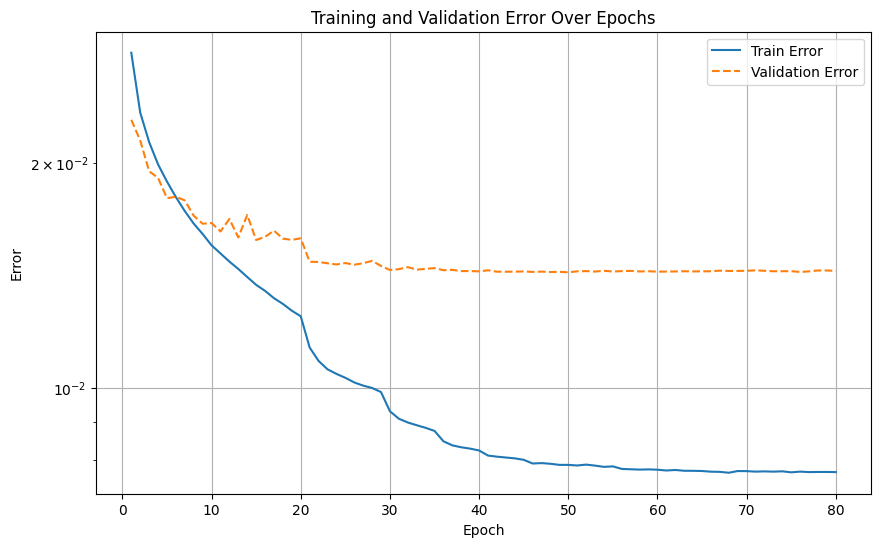

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_training_progress(csv_file):
    df = pd.read_csv(csv_file)

    plt.figure(figsize=(10,6))
    plt.plot(df['epoch'], df['train_error'], label='Train Error')
    plt.plot(df['epoch'], df['val_error'], label='Validation Error', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.yscale('log')
    plt.title('Training and Validation Error Over Epochs')
    plt.legend()
    plt.grid(True)
    
    plt.savefig("final_model/training_progress.png")
    
    plt.show()

plot_training_progress("final_model/training_log.csv")

# Part 5: Model Usage
Now, one can use our best model to predict winning percentage (white) given a standard chess board FEN notation.

This program can be run from another seperate file by loading the model saved above, or by directly running the cell below. Ensure relevant prior cells are run during the runtime to make sure the methods exist in memory.

Input state: r2q1rk1/ppp2ppp/2np1n2/3N4/2P1PB2/3P4/PP3PPP/R2Q1RK1 w - - 0 15
1/1 [==============================] - 0s 156ms/step

Predicted probability of White win: 0.59166646



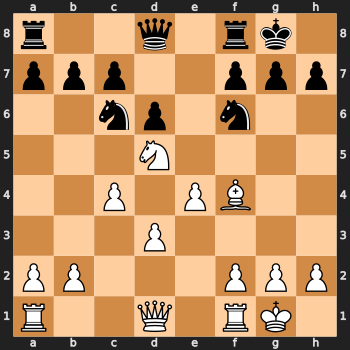

In [20]:
import numpy as np
import sys
sys.path.append('')
import chess
import tensorflow as tf
from tensorflow.keras.models import load_model
tf.get_logger().setLevel('ERROR')

def predict_from_fen(fen, model_path="best_model.h5"):
    # Load the model
    model = load_model(model_path)
    
    # Convert fen to board tensor
    board_tensor = fen_to_tensor(fen)
    
    # Compute extra features
    board = chess.Board(fen)
    piece_diff = calculate_piece_differential(board)
    mobility = calculate_mobility(board)
    king_safety = calculate_king_safety(board)
    control_key = calculate_control_of_key_squares(board)
    pawn_struct = calculate_pawn_structure(board)
    doubled_pawns_diff = pawn_struct['doubled_pawns_diff']
    isolated_pawns_diff = pawn_struct['isolated_pawns_diff']
    
    # Combine
    extra_features = np.array([piece_diff, mobility, king_safety, control_key, doubled_pawns_diff, isolated_pawns_diff], dtype=np.float32)
    
    # Reshape for prediction (add batch dimension)
    board_input = np.expand_dims(board_tensor, axis=0)   # Shape: (1, 8, 8, 13)
    extra_input = np.expand_dims(extra_features, axis=0) # Shape: (1, 6)
    
    # Predict
    prediction = model.predict([board_input, extra_input])
    return prediction[0, 0]

model_path = "final_model/best_model.h5"

fen = "r2q1rk1/ppp2ppp/2np1n2/3N4/2P1PB2/3P4/PP3PPP/R2Q1RK1 w - - 0 15"

print(f"Input state: {fen}")
pred = predict_from_fen(fen, model_path = model_path)
print()
print("Predicted probability of White win:", pred)
print()
board = chess.Board(fen)
chess.svg.board(board, size=350)